In [24]:
import pandas as pd
import numpy as np
import os, sys

# Now you can import the library as usual
import investos as inv
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

#### 4.1 Loadings 

In [3]:
# 4.1 Idiosync only for now (gonna use off-the-shelf PCA based for this)

# Step 1: loading the dataframe and join them together
# loading
df_loadings = pd.read_parquet('john_rbics_industry.parquet')
df_actual_returns = pd.read_parquet('john_return_prev_1d_open.parquet').fillna(0).rename(columns={"value": "return_1d"})
df_sizes = pd.read_parquet('john_market_cap_open_dil.parquet').fillna(0).rename(columns={"value": "size"})
df_values = pd.read_parquet('john_market_cap_open_dil_to_net_income_ltm.parquet').fillna(0).rename(columns={"value": "value"})
df_loadings = pd.get_dummies(df_loadings, columns=["industry"])

# merge these dataframe into one
df_sizes = df_sizes.merge(df_values, how='left', on=['id','datetime'])
df_actual_returns = df_actual_returns.merge(df_sizes, how='left', on=['id','datetime'])
df_loadings = pd.merge(df_actual_returns, df_loadings, how='left', on=None, left_on='id', right_on='id', left_index=False)

for col in df_loadings.columns:
    if col.startswith("industry_"):
        df_loadings[col] = df_loadings[col].astype(int)
        
#df_loadings.rename(columns={"value": "return_1d"}, inplace = True)


In [4]:
df_values.shape, df_sizes.shape, df_actual_returns.shape, df_loadings.shape

((24411633, 3), (24411633, 4), (24411633, 5), (24411633, 19))

In [5]:
df_values.columns, df_sizes.columns, df_actual_returns.columns

(Index(['id', 'datetime', 'value'], dtype='object'),
 Index(['id', 'datetime', 'size', 'value'], dtype='object'),
 Index(['id', 'datetime', 'return_1d', 'size', 'value'], dtype='object'))

In [6]:
# Step 2: Calculate momentum (e.g., 12-month cumulative return)

# sliding window size for volatiltiy and momentum 
look_back_period_volatility = 252  # Approx. 12 months for daily data
look_back_period_momentum = 30 
#df_loadings['momentum'] = df_loadings.groupby('id')['return_1d'].apply(lambda x: x.rolling(window=look_back_period_momentum).apply(lambda y: np.prod(1 + y) - 1))
df_loadings['volatility'] = df_loadings.groupby('id')['return_1d'].apply(lambda x: x.rolling(window=look_back_period_volatility).std()).reset_index(level = 'id').rename(columns={"return_1d": "volatility"}).volatility
df_loadings['momentum'] = df_loadings.groupby('id')['return_1d'].rolling(window=look_back_period_momentum).apply(lambda x: np.prod(1 + x) - 1, raw = True).reset_index(level = 'id').rename(columns={"return_1d": "momentum"}).momentum
# drop those nan values less than then window size
df_loadings.dropna(inplace = True)

In [7]:
# Step 3: identify some inf values and replace them as 0

# generate an inf mask and count the True value
df_numeric = df_loadings.apply(pd.to_numeric, errors='coerce')
inf_mask = np.isinf(df_numeric)
inf_counts = inf_mask.sum()

print('inf value count in each of the factors')
print(inf_counts)

# replace np.inf and -np.inf as 0 in df_loadings
df_loadings.replace([np.inf, -np.inf], 0, inplace=True)


# check again
df_numeric = df_loadings.apply(pd.to_numeric, errors='coerce')
inf_mask = np.isinf(df_numeric)
inf_counts = inf_mask.sum()

if inf_counts.any():
    print('there is inf value in the DataFrame')
else:
    print('no inf value in the DataFrame')

inf value count in each of the factors
id                                   0
datetime                             0
return_1d                            0
size                                 0
value                              771
industry_Business Services           0
industry_Consumer Cyclicals          0
industry_Consumer Non-Cyclicals      0
industry_Consumer Services           0
industry_Energy                      0
industry_Finance                     0
industry_Healthcare                  0
industry_Industrials                 0
industry_Non-Corporate               0
industry_Non-Energy Materials        0
industry_Other                       0
industry_Technology                  0
industry_Telecommunications          0
industry_Utilities                   0
volatility                           0
momentum                             0
dtype: int64
no inf value in the DataFrame


In [8]:
df_loadings[df_loadings.value == np.inf]

,id,datetime,return_1d,size,value,industry_Business Services,industry_Consumer Cyclicals,industry_Consumer Non-Cyclicals,industry_Consumer Services,industry_Energy,...,industry_Healthcare,industry_Industrials,industry_Non-Corporate,industry_Non-Energy Materials,industry_Other,industry_Technology,industry_Telecommunications,industry_Utilities,volatility,momentum


In [9]:
#df_loadings[df_loadings.datetime == '2023-05-11']

In [10]:
# Step 4: adding a country factor and fake a quality factor
np.random.seed(42)  # For reproducibility
df_loadings['country'] = 1
df_loadings['quality'] = np.random.randn(len(df_loadings))  # Simulating quality factor

In [11]:
# Step 5: slice the dataframe after 2022-09-07
min_dt = '2022-09-07'
df_loadings = df_loadings[df_loadings.datetime >= min_dt]

In [12]:
# testing use
#df_loadings.value.isnull().sum()
#df_loadings[df_loadings.id == 'B00FG1-R'].describe()
#df_loadings.head()
#df_loadings

#### 4.2 Calc Factor Returns

based on the datetime to obtain a regression on all different stocks

In [13]:
# Step 1: filter the outlier and standarized the style factors
def get_filter_standarized_df(df: pd.DataFrame) -> pd.DataFrame:

    def get_median_filter(x,x_M,n = 1.483):
        # filter extreme value. MAD method 
        # MAD is better than 3std away from mean method, and Inter Quantile Range(IQR) method
        #𝑥̃𝑖 = 𝑥𝑀 + 𝑛 ∗ 𝐷_𝑀𝐴𝐷, 𝑖𝑓 𝑥𝑖 > 𝑥𝑀 + 𝑛 ∗ 𝐷𝑀𝐴𝐷 
        #𝑥̃𝑖 = 𝑥𝑀 −𝑛 ∗ 𝐷𝑀𝐴𝐷,  𝑖𝑓 𝑥𝑖 < 𝑥𝑀 −𝑛 ∗ 𝐷𝑀𝐴𝐷
        #𝑥̃𝑖 = xi else

        D_MAD = abs(x - x_M)
        if x > x_M + n * D_MAD:
            return x_M + n * D_MAD
        elif x < x_M - n * D_MAD:
            return x_M - n * D_MAD
        else:
            return x
    
    def standardize(x, mean, std):
        # z-socre all style factors
        return (x - mean) / std
    
    # filter out the columns need to apply a standarization: the column should only include style factors
    style_factors_cols = [col for col in df.columns if not col.startswith('industry_') and col not in ['country', 'datetime', 'id','return_1d']]

    # apply outlier filter
    medians = df[style_factors_cols].median()
    for col in style_factors_cols:
        df.loc[:,col] = df[col].apply(lambda x: get_median_filter(x, medians[col]))

    # apply factor standarization
    means = df[style_factors_cols].mean()
    stds = df[style_factors_cols].std()

    for col in style_factors_cols:
        df.loc[:,col] = standardize(df[col], means[col], stds[col])

    return df

            

In [14]:
# Step 2: identify factor effectiveness
def get_t_statistics(model,X,y):
    predictions = model.predict(X)     
    residuals = y - predictions
    # Calculate the residual standard error
    rss = (residuals ** 2).sum()
    n = len(y)      # number of sample
    p = X.shape[1]  # number of factors
    rse = (rss / (n - p - 1)) ** 0.5
    # Calculate t-values for coefficients
    t_values = model.coef_ / rse
    print(model.coef_,rse)
    return t_values

In [15]:
# testing use
# def get_median_filter(x,x_M,n = 1.483):
#     D_MAD = abs(x - x_M)
#     if x > x_M + n * D_MAD:
#         return x_M + n * D_MAD
#     elif x < x_M - n * D_MAD:
#         return x_M - n * D_MAD
#     else:
#         return x

# def standardize(x, mean, std):
#     return (x - mean) / std
    
# df = df_loadings[df_loadings.datetime == '2023-05-11']
# number_inf = df.value[df.value == np.inf].count()
# print(number_inf)
# print(df.value)
# print(df.value.isnull().sum())
# #test_df = get_filter_standarized_df(test)
# #print(test.value)

# # filter out the columns need to apply a standarization
# style_factors_cols = [col for col in df.columns if not col.startswith('industry_') and col not in ['country', 'datetime', 'id','return_1d']]
# print(style_factors_cols)
# # apply outlier filter
# medians = df[style_factors_cols].median()
# print(medians)
# means = df[style_factors_cols].mean()
# stds = df[style_factors_cols].std()
# print(means,stds)

# for col in style_factors_cols:
#     df.loc[:,col] = df[col].apply(lambda x: get_median_filter(x, medians[col]))
# print(df.value)
# print(df.value.isnull().sum())
# # apply factor standarization
# means = df[style_factors_cols].mean()
# stds = df[style_factors_cols].std()
# print(means,stds)
# for col in style_factors_cols:
#     df.loc[:,col] = standardize(df[col], means[col], stds[col])
# print(df.value)
# print(df.value.isnull().sum())

In [16]:
# Step 3: Dictionary to store regression results

"""
1.
it comes out with an warning like this:
# /var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_29543/1917117034.py:11: RuntimeWarning: invalid value encountered in divide
#  t_values = model.coef_ / rse

this is caused by t_values = model.coef_ / rse while certain model.coef_ value is too low (about e-17 level). Overall the code is fine.
We can just mute this warning later

2. some results shows [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0 which model.coef_ is a zero list, and rse is zero 
as well
"""

factor_returns = {}

# Iterating over each distinct date
for d in df_loadings["datetime"].unique():
    # Isolating the data for the current date
    df_current = df_loadings[df_loadings["datetime"] == d]

    # outlier modification and factor standarization
    df_current = get_filter_standarized_df(df_current)

    # identify factor effectiveness
    # Defining the dependent variable (y) and independent variables (X)
    y = df_current["return_1d"]
    X = df_current.drop(columns=["return_1d", "datetime", "id"])
    
    #Performing linear regression
    model = LinearRegression(fit_intercept=False).fit(X, y)

    t_values = get_t_statistics(model,X,y)
    
    # Print t-values for each factor
    # print("T-Values:")
    # for i, factor in enumerate(X.columns):
    #     print(f"{factor}: {t_values[i]}")
    
    # Storing the coefficients and intercept
    factor_returns[d] = {
        "coefficients": model.coef_,
        "intercept": model.intercept_,
        "feature_names": model.feature_names_in_,
        "r2": model.score(X, y),
         # t_values added to the factor_returns dataframe
        "t-values": t_values     
    }

[ 5.60528432e-04 -6.92999814e-04 -4.88728618e-02 -6.22133766e-02
 -5.92368206e-02 -5.98009981e-02 -8.30012888e-02 -6.08175113e-02
 -6.16389346e-02 -5.45369313e-02  1.81278603e-16 -6.31373650e-02
  3.12250226e-16 -5.48200013e-02 -6.24244096e-02 -5.45100800e-02
 -6.32781682e-03  5.42839439e-03  4.45441021e-02  6.89099223e-04] 0.0279036468262443
[ 1.41466433e-05  1.01228107e-03  2.85634086e-02  3.11691554e-02
  3.64070460e-02  3.17989187e-02  2.22077829e-02  3.27807959e-02
  4.72572470e-02  3.34012181e-02  4.92661467e-16  3.84413071e-02
 -1.89084859e-16  2.80592479e-02  2.26142595e-02  3.92376342e-02
  3.07578586e-03  5.17477206e-03 -1.80581600e-02 -2.22844359e-05] 0.02754761937607804
[-5.87484727e-05  9.02895056e-05 -1.05655505e-02 -3.10697220e-03
 -4.89175024e-03  2.90856066e-03 -6.53540249e-04  5.38317314e-03
  8.32640161e-03  4.37562331e-04  2.98155597e-19  5.07550634e-03
  3.46944695e-18  8.75060037e-03 -1.55271133e-02 -7.79955329e-03
  7.03344651e-03  4.68137194e-03  2.28961164e-02 

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 8.90317725e-04 -2.72192893e-04  3.33916597e-02  2.26696054e-02
  2.37928721e-02  2.22612253e-02  1.29545899e-02  2.70996962e-02
  3.09487308e-02  2.73290617e-02  2.13804668e-16  2.96020549e-02
  9.88792381e-17  4.13802387e-02  2.83118220e-02  3.46292666e-02
  5.35204803e-03  3.50276910e-03  1.51905683e-03  3.76353634e-04] 0.03434668438574995
[-4.50735012e-04  1.79050191e-04 -2.87529876e-03 -9.96775124e-03
 -3.27470554e-03 -7.70323263e-03 -1.71216017e-02 -7.46361600e-03
  3.85970305e-05 -7.13818595e-03 -1.64798730e-17 -6.65654738e-03
 -2.42861287e-17 -1.34132085e-03 -1.25514228e-02 -1.81061703e-02
 -2.97765877e-04  4.17596375e-03 -8.64666413e-03  9.60503995e-04] 0.029687721223225275
[-5.83037911e-04 -7.15049049e-04  9.42245005e-03  1.38469229e-02
  1.48080555e-02  8.32028393e-03  1.94219836e-02  1.13707648e-02
  1.97935684e-02  1.77693037e-02 -9.41087486e-17  1.77373305e-02
  9.10729825e-17  1.19425420e-02  1.20544977e-02  9.62083583e-03
  7.10806037e-03  4.45269168e-03 -1.78761961e-0

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse
/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 8.59889213e-04  4.46496677e-04 -1.52975451e-02 -1.81431901e-02
 -1.62049450e-02 -2.47277132e-02 -1.58200093e-02 -1.57167918e-02
 -3.62869659e-02 -1.75977963e-02  7.41594286e-17 -1.48702421e-02
  2.49908601e-16 -2.41857723e-02 -1.82552668e-02 -1.26963856e-02
  4.90551395e-03  8.84643909e-03  1.14940514e-02 -1.19863368e-05] 0.027590671317549484
[-9.88238410e-05 -1.49045624e-04 -1.91808792e-02 -1.70409374e-02
 -2.17846041e-02 -2.06645956e-02 -4.47145281e-02 -2.10020245e-02
 -4.82981143e-03 -1.94886287e-02  1.65666092e-16 -2.46426742e-02
 -4.28476699e-16 -1.09966070e-02 -2.27504171e-02 -1.89351369e-02
  6.00381307e-03  1.53584736e-03  1.29870002e-02  8.00186420e-04] 0.02824089422989603
[-1.96385602e-03 -2.50351230e-04  4.40433002e-02  4.47242409e-02
  3.63388218e-02  4.22112569e-02  5.25687363e-02  4.07119196e-02
  5.77720969e-02  4.08615190e-02  1.70870262e-16  3.86315853e-02
 -7.18175519e-16  4.92220437e-02  4.70025561e-02  3.52024602e-02
 -1.17168079e-06  1.31150419e-03 -3.26051111e-0

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 4.95076876e-04 -9.69288088e-04  3.51320520e-02  3.96112276e-02
  2.85686942e-02  3.04543964e-02  2.57546001e-02  2.91219020e-02
  2.58719589e-02  3.18348368e-02 -2.07299455e-16  3.10880413e-02
  4.99600361e-16  3.75582106e-02  3.35400714e-02  2.53748128e-02
  3.33995446e-05  4.99780454e-03 -1.56231327e-02 -9.47431573e-04] 0.02994022359319283
[-2.66915996e-04 -5.49788845e-04  2.56783835e-03  1.48501679e-02
  5.12859030e-03  7.39036658e-03 -1.32104246e-03  3.38872639e-03
 -4.35782359e-05  7.80030881e-03 -6.28837260e-18  1.04426954e-03
  2.92734587e-17  1.69587016e-02  1.04476462e-03  3.90948707e-03
 -4.77294079e-05  1.51055106e-03  1.43671939e-03 -4.77675905e-04] 0.02766278517973906
[ 4.89973915e-04 -1.46553121e-04 -9.08039407e-03 -1.47193181e-02
 -8.76550393e-03 -1.19484631e-02 -1.37278410e-02 -1.09678840e-02
 -7.02973041e-03 -9.99548902e-03 -4.16333634e-17 -9.05535550e-03
 -2.03830008e-16 -2.11840457e-02 -3.05480149e-03 -6.36741839e-03
  1.70507284e-04  2.28425795e-03  2.75487555e-03

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[-1.56660342e-04  5.82696736e-04  2.99413478e-02  2.97952738e-02
  2.85566032e-02  2.35890869e-02  1.79529137e-02  2.92781694e-02
  3.65612210e-02  3.22473438e-02  6.76542156e-17  4.05939937e-02
  3.29597460e-17  3.34571914e-02  3.84115339e-02  3.24387148e-02
  6.13874865e-03  1.30639007e-02 -3.12910289e-02 -1.42969184e-05] 0.04333045258053611
[-2.64413044e-04  7.77339938e-04 -1.59322924e-02 -2.04893645e-02
 -1.50323406e-02 -1.49971216e-02  6.48059449e-03 -1.80655527e-02
 -1.09164596e-02 -1.35722460e-02  5.63785130e-17 -9.30430731e-03
  3.12250226e-17 -2.19892857e-02 -1.74390378e-02 -2.11667886e-02
 -7.25517644e-03  7.92519986e-03  5.46584672e-03  3.97861989e-04] 0.03316813761900876
[ 7.75923946e-05 -1.28930290e-03  3.55606002e-03  1.41993385e-02
  1.00117087e-02  1.21851780e-02  2.16416660e-03  3.03099384e-03
  6.41727091e-03  1.06883615e-02  1.25875872e-16  1.39372998e-02
  3.70255042e-17  1.60361705e-02  3.34114716e-03  1.37965537e-02
  6.61090557e-04  6.38408503e-03  7.47584309e-03

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 1.66618964e-05  1.15541944e-03 -1.50313442e-02 -2.11284925e-02
 -1.86357994e-02 -1.21984325e-02 -2.21135710e-02 -1.00264453e-02
 -8.71036831e-03 -1.85898240e-02 -2.16840434e-17 -1.66045112e-02
 -3.29597460e-17 -1.26207594e-02 -1.29634657e-02 -1.71067630e-02
  4.23421044e-03  3.32039816e-03  1.40489582e-02 -9.45024286e-05] 0.025548656493824262
[-1.18978138e-03 -7.47140221e-04  3.94124322e-02  3.94077215e-02
  2.55691358e-02  3.33706100e-02  2.41806452e-02  2.71189732e-02
  1.28416605e-02  3.70659320e-02  2.93168267e-16  3.28593251e-02
 -6.11490025e-16  2.81313725e-02  2.31700493e-02  1.54581982e-02
  3.76942709e-03  5.88787953e-03 -1.09275049e-02  3.92421449e-04] 0.03268202870433668
[-9.81546644e-04 -2.61619642e-05 -2.08094044e-02 -1.06455296e-02
 -2.16240993e-02 -1.64326196e-02 -2.15945950e-02 -1.69128931e-02
 -1.83252256e-02 -1.66465543e-02  4.42354486e-17 -1.56614838e-02
 -1.81278603e-16 -2.35838297e-02 -1.64546527e-02 -2.21713528e-02
  6.78530302e-03  5.12039002e-03  3.27873700e-0

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 1.59749578e-04  2.46707881e-04  5.10167297e-02  4.78607021e-02
  4.85736885e-02  4.58383402e-02  4.49176250e-02  5.45213596e-02
  4.97515329e-02  5.27598034e-02 -2.25947733e-16  4.78826084e-02
 -4.33680869e-16  4.29451336e-02  5.80882005e-02  5.85630889e-02
 -1.30267255e-03  5.48152260e-03 -6.06120469e-02 -1.29261970e-04] 0.027433332966682992
[ 1.77692453e-05 -1.99490050e-05 -5.64951287e-02 -7.01595909e-02
 -6.13361891e-02 -5.44659510e-02 -5.28636352e-02 -5.74643469e-02
 -4.56950852e-02 -6.81066302e-02  2.66496894e-16 -6.32831604e-02
 -1.49186219e-16 -5.15075665e-02 -6.29892014e-02 -4.50784356e-02
 -3.31426212e-04  2.79321603e-03  5.43563209e-02  1.74137527e-04] 0.026328355961509682
[-1.93392099e-04 -4.12526033e-04  1.18725736e-02  1.24439726e-02
  7.56053461e-03  1.73969707e-02  3.20286800e-02  1.74894422e-02
  9.50196399e-03  2.16283217e-02 -1.11022302e-16  2.77375543e-02
 -1.73472348e-18  9.34830608e-03 -3.50295649e-04 -7.92396822e-03
  3.03866776e-03  7.62992148e-03  6.29085067e-

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 1.42163964e-04  1.76806984e-04  1.54669685e-02  2.23710587e-02
  1.44359576e-02  1.47148687e-02  2.22483360e-02  1.78872979e-02
  1.54418369e-02  1.71488540e-02 -1.61329283e-16  2.15108838e-02
 -1.07552856e-16  1.58426051e-02  2.69176119e-02  4.25073423e-03
 -1.59799623e-03  4.56045741e-03 -1.96251692e-02 -8.29826201e-05] 0.030640318523876706
[-7.22544749e-04  5.13089499e-04 -7.91060724e-03 -8.64976869e-03
 -9.86109317e-03 -5.92930243e-03 -6.29400568e-03 -5.16909255e-03
 -1.78975651e-02 -1.07892337e-02 -1.87295925e-17 -4.76983277e-03
 -8.67361738e-17 -1.60165634e-02  4.96191661e-03 -2.08560187e-03
 -1.69099658e-03  8.82892000e-03  1.41843503e-02  8.02535741e-05] 0.036671738343014015
[-3.81938764e-04  2.74360285e-05 -6.23288762e-02 -5.31381457e-02
 -6.15491548e-02 -5.35000775e-02 -6.35001412e-02 -6.10494905e-02
 -6.34190631e-02 -5.34932253e-02  1.67183975e-16 -6.18276483e-02
 -1.21430643e-17 -5.95341831e-02 -4.33537206e-02 -6.44478730e-02
 -1.31657875e-03  1.00073620e-02  6.77539983e-

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 7.62868132e-05  1.50344390e-04  2.47989483e-02  2.30860818e-02
  2.23879640e-02  2.79822622e-02  1.57131502e-02  2.28504882e-02
  2.42050819e-02  2.00406361e-02  2.42861287e-17  2.42380941e-02
 -9.88792381e-17  2.58585351e-02  2.50131983e-02  1.60987805e-02
 -2.13197917e-03  2.78799459e-03 -2.71684123e-02  2.48839013e-05] 0.023839774838132436
[-1.24283074e-03  5.64045790e-05 -3.47682263e-02 -3.61218882e-02
 -3.59994190e-02 -2.90877818e-02 -1.02657252e-02 -3.03197744e-02
 -3.69837853e-02 -3.06707323e-02  1.58727198e-16 -2.90491107e-02
 -1.61329283e-16 -3.81953020e-02 -2.75701298e-02 -4.00115828e-02
  5.10323017e-03  7.23330028e-03  4.41094698e-02  6.47825583e-04] 0.02658936913909358
[-1.72030856e-03  1.53235249e-04  3.80685801e-02  4.32610296e-02
  3.22121469e-02  4.36795094e-02  3.28465103e-02  3.82170723e-02
  4.79226815e-02  4.03753404e-02 -1.87566976e-16  4.28291292e-02
 -2.21177243e-17  4.84571544e-02  1.73980212e-02  2.95826933e-02
  3.08086775e-03  7.47193482e-03 -2.19801529e-0

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[ 5.89391845e-04 -2.17867527e-04  1.05299508e-02  1.39275106e-02
  1.89517335e-02  1.55436665e-02  2.09424590e-02  1.79736770e-02
  1.23968760e-02  1.20796812e-02 -1.06251813e-17  2.13250106e-02
 -3.46944695e-18  1.22732581e-02  1.50535707e-02  1.61205477e-02
  7.21089742e-04  3.96466912e-03 -1.17302789e-02 -3.79311309e-04] 0.02650251772759824
[ 3.84996304e-04 -4.10784453e-04 -1.43689534e-02 -1.34273068e-02
 -2.87090233e-03 -1.17617053e-02 -1.87775570e-02 -1.15334087e-02
 -6.40387665e-03 -1.40388869e-02 -9.45424294e-17 -1.21136144e-02
 -1.06685494e-16 -1.88100739e-02 -1.19986973e-02 -1.48779480e-03
  2.16235980e-03  7.97738674e-03  6.25164253e-03  2.63804110e-04] 0.02783250093984201
[-1.91572436e-04 -1.78467109e-04  2.45041895e-02  2.55363282e-02
  1.72102549e-02  2.60562188e-02  3.40451028e-02  2.90813618e-02
  2.11453293e-02  2.37623241e-02 -4.32813507e-16  2.58063654e-02
  7.97972799e-17  1.88468770e-02  2.85048020e-02  2.84246549e-02
  1.34126282e-03  1.94809038e-03 -2.31543027e-02

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[-2.26620426e-03  3.74552299e-04  1.15170959e-02  2.19518205e-02
  1.53023688e-02  1.71898097e-02  6.55633584e-03  2.11252905e-02
  7.27590004e-03  2.38515830e-02  6.15826834e-17  9.43964584e-03
 -6.41847686e-17  5.03810574e-03  2.14422011e-02  1.37917040e-02
  1.09483003e-02  1.22154568e-02  1.15636067e-02 -5.30180943e-04] 0.0480667941436799
[-9.97304485e-04  2.95853607e-04  2.80668973e-02  1.80047846e-02
  3.63737363e-02  1.30677295e-02  1.56249154e-02  2.70820559e-02
  2.58701943e-02  2.65606777e-02  2.42861287e-17  1.74567516e-02
 -1.11022302e-16  1.80362157e-02  2.23891029e-02  2.67737855e-02
  3.88165142e-03  4.10725363e-03 -1.48014111e-02  6.71173264e-05] 0.03427108247555708
[ 1.29003952e-03 -1.71954169e-04 -2.21057205e-02 -1.91721124e-02
 -2.04121592e-02 -2.19004399e-02 -3.27172833e-02 -1.42050376e-02
 -1.63591909e-02 -2.24827605e-02  6.85215773e-17 -2.18398717e-02
 -8.32667268e-17 -1.26790437e-02 -3.66555677e-02 -1.72953977e-02
 -3.86465769e-03  5.97312405e-03  1.49859202e-02 

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse
/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0
[ 7.80843668e-04  5.73516737e-05 -1.78036664e-02 -2.34188473e-02
 -1.94438476e-02 -2.04938537e-02 -8.73484042e-03 -2.55733097e-02
 -2.68741590e-02 -2.28291755e-02 -9.70360944e-18 -2.46561521e-02
  1.38127357e-16 -2.95796330e-02 -7.99047967e-03 -1.74838135e-02
 -4.39526255e-03 -1.85088288e-03  7.04509567e-03 -5.93034691e-04] 0.026324485723742682
[ 2.51072059e-04  1.23920699e-04 -1.06466281e-02 -1.37658337e-02
  4.53259195e-03 -1.18687350e-02 -7.14588884e-03 -8.21577600e-03
  1.32796647e-02 -1.61777595e-02 -1.56125113e-17 -1.46366722e-02
  2.77555756e-17 -2.52326225e-02 -5.80465543e-04  7.98135784e-03
 -7.02566226e-03  9.28407371e-04 -3.83782074e-05  3.39925284e-04] 0.03195888696905306
[ 1.65467428e-03  1.24403975e-04  1.43220464e-02  6.14577541e-03
  1.38985483e-02  1.77289204e-02  5.02742899e-02  2.05872489e-02
  1.16667504e-02  1.97455070e-02 -6.50521303e-18  1.78096103e-02
 -1.25333771e-16  1.62760485e-02  2.17415733e-

/var/folders/sg/1nh38dx53_zc3kxcq1cq1f000000gn/T/ipykernel_31632/1346092922.py:11: RuntimeWarning: invalid value encountered in divide
  t_values = model.coef_ / rse


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0
[ 1.46766761e-03  1.03178522e-04  8.18644006e-04 -1.74906419e-02
  7.35065022e-04 -6.64596955e-03  4.96398577e-03 -7.61199169e-03
 -6.54458997e-03 -3.82667118e-03 -6.93889390e-18 -5.19929972e-03
  1.38777878e-17 -4.93134293e-03  3.07769694e-02 -1.35866106e-03
 -2.46672261e-03  3.46217417e-03 -1.30030225e-02  6.31483017e-04] 0.03508168676882164
[ 5.96838896e-04 -2.75293410e-04 -5.74475336e-04 -9.26656269e-03
 -7.50313552e-03 -9.29471983e-04 -2.12596228e-02 -1.07939747e-02
 -7.67584217e-03 -1.66461666e-02 -1.60461922e-17 -1.59103117e-02
  3.81639165e-17 -3.88098093e-03 -8.86752812e-03 -1.78283150e-02
 -1.02766640e-02  5.25995510e-03 -9.38541020e-03  2.74261628e-05] 0.03164073971229941
[-6.95281520e-04  2.03253782e-04 -6.23307597e-04  7.84796350e-03
 -3.26140192e-03  1.10411156e-02 -2.93916052e-04  1.08144953e-03
 -4.12372502e-03  1.72661404e-03 -4.33680869e-19 -3.61597783e-03
  8.67361738e-18  6.47858877e-03 -1.08706601e-0

In [17]:
factor_returns

{Timestamp('2022-09-07 00:00:00'): {'coefficients': array([ 5.60528432e-04, -6.92999814e-04, -4.88728618e-02, -6.22133766e-02,
         -5.92368206e-02, -5.98009981e-02, -8.30012888e-02, -6.08175113e-02,
         -6.16389346e-02, -5.45369313e-02,  1.81278603e-16, -6.31373650e-02,
          3.12250226e-16, -5.48200013e-02, -6.24244096e-02, -5.45100800e-02,
         -6.32781682e-03,  5.42839439e-03,  4.45441021e-02,  6.89099223e-04]),
  'intercept': 0.0,
  'feature_names': array(['size', 'value', 'industry_Business Services',
         'industry_Consumer Cyclicals', 'industry_Consumer Non-Cyclicals',
         'industry_Consumer Services', 'industry_Energy',
         'industry_Finance', 'industry_Healthcare', 'industry_Industrials',
         'industry_Non-Corporate', 'industry_Non-Energy Materials',
         'industry_Other', 'industry_Technology',
         'industry_Telecommunications', 'industry_Utilities', 'volatility',
         'momentum', 'country', 'quality'], dtype=object),
  'r2': 

In [18]:
list_to_insert = [
    [k, factor_returns[k]["r2"], *factor_returns[k]["t-values"],*factor_returns[k]["coefficients"]]
    for k in factor_returns    # iterative through the factor returns dict
]
#print(list_to_insert)
cols = df_loadings.drop(columns=["return_1d", "datetime", "id"]).columns

cols_with_t_values = ['t_values_' + col for col in cols]

# df_factor_returns = df.append(pd.Series(list_to_insert, index=['date', 'r2', *cols]), ignore_index=True)  # using append
df_factor_returns = pd.DataFrame(list_to_insert, columns=["datetime", "r2", *cols_with_t_values, *cols])


In [19]:
df_factor_returns

,datetime,r2,t_values_size,t_values_value,t_values_industry_Business Services,t_values_industry_Consumer Cyclicals,t_values_industry_Consumer Non-Cyclicals,t_values_industry_Consumer Services,t_values_industry_Energy,t_values_industry_Finance,...,industry_Non-Corporate,industry_Non-Energy Materials,industry_Other,industry_Technology,industry_Telecommunications,industry_Utilities,volatility,momentum,country,quality
0,2022-09-07,0.119220,0.020088,-0.024835,-1.751487,-2.229579,-2.122906,-2.143125,-2.974568,-2.179554,...,1.812786e-16,-0.063137,3.122502e-16,-0.054820,-0.062424,-0.054510,-0.006328,0.005428,0.044544,0.000689
1,2022-09-08,0.119792,0.000514,0.036747,1.036874,1.131465,1.321604,1.154325,0.806160,1.189968,...,4.926615e-16,0.038441,-1.890849e-16,0.028059,0.022614,0.039238,0.003076,0.005175,-0.018058,-0.000022
2,2022-09-09,0.131458,-0.001983,0.003048,-0.356705,-0.104895,-0.165151,0.098196,-0.022064,0.181742,...,2.981556e-19,0.005076,3.469447e-18,0.008751,-0.015527,-0.007800,0.007033,0.004681,0.022896,-0.000368
3,2022-09-12,0.112668,0.006120,-0.016160,-1.416544,-1.077206,-1.421137,-1.241298,-1.404733,-1.485397,...,-2.428613e-16,-0.031343,4.336809e-17,-0.035006,-0.028293,-0.046189,0.007015,0.000459,0.057246,-0.000246
4,2022-09-13,0.075042,-0.003627,-0.003730,0.991018,0.781361,0.929494,0.769388,0.953473,0.862553,...,4.172010e-16,0.023401,2.393918e-16,0.024211,0.027651,0.036939,-0.006941,0.007170,-0.049792,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2024-01-25,0.168430,0.013454,0.001458,0.008657,-0.384988,-0.142241,0.001780,0.556616,0.058053,...,2.602085e-18,-0.004255,-2.341877e-17,-0.003903,-0.005484,-0.006933,-0.003222,0.010202,-0.004797,0.000409
362,2024-01-26,0.047154,-0.002530,0.010886,-0.166000,0.065169,0.135284,0.026405,-0.148886,-0.123213,...,-1.214306e-17,0.002169,6.505213e-18,-0.013133,-0.005710,0.005998,0.001003,0.003665,0.005413,0.000772
363,2024-01-29,0.110857,0.021514,-0.001426,0.376696,0.339890,0.245844,0.063726,0.613373,0.344880,...,-9.637202e-17,0.008536,4.510281e-17,0.003355,0.013634,0.006340,0.003876,0.007798,-0.007503,-0.000475
364,2024-01-30,0.145170,-0.002428,0.001203,0.296741,0.362811,0.124365,0.328859,-0.214570,0.324630,...,1.409463e-17,0.011786,5.421011e-17,0.017242,-0.001641,0.014344,0.007908,0.006495,-0.000978,-0.000467


In [25]:
#### Step 4: Return Model: Multicollinearity check
# 1. check absolute average correlation
# 2. check absolute median correlation
# 3. check t-values 

# same category of style factors K, use first M months data as sample
start_date = '2022-09-07'
M = 6
cols = ['datetime','country','value','momentum','size','volatility','quality']   #datetime must be included!
# Filter data for the last 3 months
start_date = df_factor_returns['datetime'].min()  # Assuming the data contains the latest date
end_date = start_date + pd.DateOffset(months=M) + pd.offsets.MonthEnd(0)
print(end_date)
filtered_factor_return_df = df_factor_returns[(df_factor_returns['datetime'] >= start_date) & (df_factor_returns['datetime'] <= end_date)].loc[:,cols]

# Split the filtered data by month
month_data = {}
current_date = start_date
while current_date <= end_date:
    current_month_data = filtered_factor_return_df[filtered_factor_return_df['datetime'].dt.month == current_date.month].drop(['datetime'], axis = 1) # drop the datatime column in 1
    month_data[str(current_date.year)+ '-'+ str(current_date.month)] = current_month_data
    current_date += pd.DateOffset(days=1)


corr_matrices = {}
multiindex_dataframes = []
for period, df_month in month_data.items():
    # Assuming your factor loading columns start with 'factor_loading_'
    
    # obtain the correlation and then take the absolute value
    df_corr = df_month.corr().abs()
    corr_matrices[period] = df_corr
    # generate two level of indexs, and then concat the correlation matrix to the bottom
    multiindex = pd.MultiIndex.from_product([[period], df_corr.index], names=['Date', 'Factor'])
    df_corr_with_multiindex = df_corr.set_index(multiindex)
    multiindex_dataframes.append(df_corr_with_multiindex)

df_3d = pd.concat(multiindex_dataframes,axis = 0)

# Perform element-wise addition by summing over the first index level ('Date')
df_median = df_3d.groupby(level = 'Factor').median()

# Perform element-wise average by taking the mean over the first index level ('Date')
df_mean = df_3d.groupby(level='Factor').mean()



2023-03-31 00:00:00


In [26]:
#list(corr_matrices.keys())

In [27]:
factor_pairs = [(i, j) for i in corr_matrices[list(corr_matrices.keys())[0]].columns for j in corr_matrices[list(corr_matrices.keys())[0]].columns if i != j]
aggregated_corrs = {pair: [] for pair in factor_pairs}

for period, corr_matrix in corr_matrices.items():
    for pair in factor_pairs:
        aggregated_corrs[pair].append(corr_matrix.loc[pair[0], pair[1]])


In [28]:
t_test_results = {}
for pair, corrs in aggregated_corrs.items():
    # Since we need at least two samples for t-test, ensure there are enough time periods
    if len(corrs) > 1:
        t_stat, p_value = ttest_ind(corrs, corrs)  # Perform t-test on correlation coefficients
        #print(t_stat,p_value)
        t_test_results[pair] = (t_stat, p_value)

In [29]:
corrs

[0.4593569924033293,
 0.03197122938152712,
 0.41972574389691536,
 0.3894045663841044,
 0.2184621821429324,
 0.12365359317504525,
 0.31125774794107924]

In [30]:


# Display the results
print("Element-wise Sum:\n", df_median)
print("Element-wise Average:\n", df_mean)

Element-wise Sum:
              country     value  momentum      size  volatility   quality
Factor                                                                  
country     1.000000  0.287741  0.105262  0.163855    0.311893  0.204356
momentum    0.105262  0.048835  1.000000  0.213559    0.407093  0.272905
quality     0.204356  0.236731  0.272905  0.293750    0.311258  1.000000
size        0.163855  0.314818  0.213559  1.000000    0.174965  0.293750
value       0.287741  1.000000  0.048835  0.314818    0.322480  0.236731
volatility  0.311893  0.322480  0.407093  0.174965    1.000000  0.311258
Element-wise Average:
              country     value  momentum      size  volatility   quality
Factor                                                                  
country     1.000000  0.303699  0.138980  0.270828    0.337899  0.207745
momentum    0.138980  0.159182  1.000000  0.219614    0.430826  0.272691
quality     0.207745  0.216132  0.272691  0.244717    0.279119  1.000000
size     

In [31]:
df_mean

,country,value,momentum,size,volatility,quality
Factor,,,,,,
country,1.000000,0.303699,0.138980,0.270828,0.337899,0.207745
momentum,0.138980,0.159182,1.000000,0.219614,0.430826,0.272691
quality,0.207745,0.216132,0.272691,0.244717,0.279119,1.000000
size,0.270828,0.383031,0.219614,1.000000,0.330150,0.244717
value,0.303699,1.000000,0.159182,0.383031,0.340905,0.216132
volatility,0.337899,0.340905,0.430826,0.330150,1.000000,0.279119


In [32]:
df_median

,country,value,momentum,size,volatility,quality
Factor,,,,,,
country,1.000000,0.287741,0.105262,0.163855,0.311893,0.204356
momentum,0.105262,0.048835,1.000000,0.213559,0.407093,0.272905
quality,0.204356,0.236731,0.272905,0.293750,0.311258,1.000000
size,0.163855,0.314818,0.213559,1.000000,0.174965,0.293750
value,0.287741,1.000000,0.048835,0.314818,0.322480,0.236731
volatility,0.311893,0.322480,0.407093,0.174965,1.000000,0.311258


In [21]:
# # res dataframe to store some of the result from the model
# r2 = []
# res = pd.DataFrame(df_loadings["datetime"].unique(),
#                   columns=['date'])
# res.rename
# for d in df_loadings["datetime"].unique():
#     r2.append(factor_returns[d]['r2'])
# res['r2'] = r2

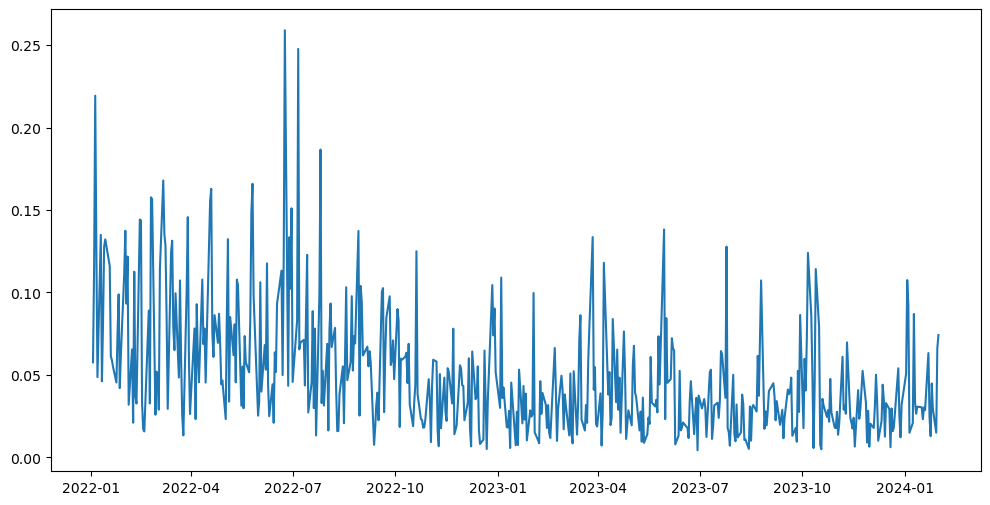

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))  
plt.plot(df_factor_returns[df_factor_returns.r2 != 1].datetime,df_factor_returns[df_factor_returns.r2 != 1].r2)

In [23]:
df_factor_returns.describe()

,datetime,r2,industry_Business Services,industry_Consumer Cyclicals,industry_Consumer Non-Cyclicals,industry_Consumer Services,industry_Energy,industry_Finance,industry_Healthcare,industry_Industrials,industry_Non-Corporate,industry_Non-Energy Materials,industry_Other,industry_Technology,industry_Telecommunications,industry_Utilities,country
count,543,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,5.430000e+02,543.000000,5.430000e+02,543.000000,543.000000,543.000000,543.000000
mean,2023-01-16 14:27:10.939226624,0.087336,0.000130,-0.000333,0.029584,0.000040,0.001350,0.000081,-0.000096,0.000143,1.694156e-17,0.000013,-1.845804e-17,-0.000158,-0.000536,-0.000146,0.000033
min,2022-01-03 00:00:00,0.004318,-0.072573,-0.085983,-0.074722,-0.083875,-0.086207,-0.069563,-0.083243,-0.076772,-1.449361e-15,-0.070039,-7.993606e-15,-0.091131,-0.068364,-0.075838,-0.085401
25%,2022-07-11 12:00:00,0.023975,-0.011761,-0.012875,-0.010808,-0.013739,-0.012413,-0.012526,-0.014008,-0.012123,-1.051676e-16,-0.012108,-4.423545e-17,-0.015757,-0.012497,-0.011798,-0.009857
50%,2023-01-17 00:00:00,0.041176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.276825e-18,0.000000,0.000000e+00,0.000000,-0.000168,0.000000,0.000000
75%,2023-07-25 12:00:00,0.071359,0.012154,0.013978,0.012750,0.013730,0.016397,0.011706,0.015435,0.014093,7.762888e-17,0.014025,2.927346e-17,0.014613,0.012007,0.010862,0.010207
max,2024-01-31 00:00:00,1.000000,0.107886,0.119526,16.148108,0.113647,0.110771,0.109061,0.117364,0.110521,1.676437e-14,0.115688,8.482798e-16,0.118499,0.109830,0.104027,0.072125
std,NaN,0.187007,0.021221,0.023806,0.693301,0.023026,0.026153,0.020798,0.024777,0.021733,7.767863e-16,0.021836,3.691227e-16,0.024788,0.020834,0.021117,0.019881


In [24]:
df_factor_returns.shape, df_loadings.shape

((543, 17), (1772724, 18))

#### 4.3 Calc idiosyncratic risk

In [25]:
factor_cols = [
    col
    for col in df_factor_returns.columns
    if col in df_loadings.columns and col != "datetime"
]

In [26]:
# Merge the DataFrames on 'date'
df_idio = pd.merge(
    df_loadings, df_factor_returns, on="datetime", suffixes=("", "_factor_returns")
)

In [27]:
df_idio

,id,datetime,return_1d,industry_Business Services,industry_Consumer Cyclicals,industry_Consumer Non-Cyclicals,industry_Consumer Services,industry_Energy,industry_Finance,industry_Healthcare,...,industry_Finance_factor_returns,industry_Healthcare_factor_returns,industry_Industrials_factor_returns,industry_Non-Corporate_factor_returns,industry_Non-Energy Materials_factor_returns,industry_Other_factor_returns,industry_Technology_factor_returns,industry_Telecommunications_factor_returns,industry_Utilities_factor_returns,country_factor_returns
0,B00FG1-R,2022-01-03,0.007993,0,0,0,0,1,0,0,...,-0.002757,-0.010930,0.001127,-1.647987e-17,-0.001435,-1.734723e-18,-0.010530,-0.011001,-0.002800,0.009963
1,B00FG1-R,2022-01-04,0.051982,0,0,0,0,1,0,0,...,0.031035,0.039688,0.028505,-2.688821e-16,0.029450,6.245005e-17,0.023904,0.033814,0.015475,-0.021470
2,B00FG1-R,2022-01-05,0.046901,0,0,0,0,1,0,0,...,0.020359,-0.014070,0.021085,-1.088539e-16,0.025275,2.428613e-17,-0.008196,0.014186,0.008539,-0.016110
3,B00FG1-R,2022-01-06,0.006400,0,0,0,0,1,0,0,...,-0.022200,-0.053499,-0.033731,2.454634e-16,-0.027091,-6.245005e-17,-0.050031,-0.023251,-0.015735,0.007333
4,B00FG1-R,2022-01-07,0.018283,0,0,0,0,1,0,0,...,0.016627,0.000867,0.004411,-3.035766e-17,0.005352,-1.327063e-16,0.012492,0.006999,0.003509,-0.010072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772719,XR7GZL-R,2024-01-25,0.013636,0,0,0,0,0,1,0,...,-0.003249,-0.010975,-0.012079,-3.382711e-17,-0.011374,3.599551e-17,-0.008282,-0.009418,-0.015710,0.000481
1772720,XR7GZL-R,2024-01-26,-0.003523,0,0,0,0,0,1,0,...,-0.005192,0.000317,-0.003560,-4.076600e-17,-0.000352,-6.938894e-18,-0.014463,-0.006973,0.002714,0.006865
1772721,XR7GZL-R,2024-01-29,-0.011250,0,0,0,0,0,1,0,...,0.005395,0.000942,0.000526,4.857226e-17,0.003068,8.239937e-18,0.001535,0.012398,-0.001287,-0.005036
1772722,XR7GZL-R,2024-01-30,0.002276,0,0,0,0,0,1,0,...,0.009457,0.028996,0.012458,1.077697e-16,0.009645,1.821460e-17,0.019139,-0.000140,0.008372,-0.001964


In [28]:
df_idio

,id,datetime,return_1d,industry_Business Services,industry_Consumer Cyclicals,industry_Consumer Non-Cyclicals,industry_Consumer Services,industry_Energy,industry_Finance,industry_Healthcare,...,industry_Finance_factor_returns,industry_Healthcare_factor_returns,industry_Industrials_factor_returns,industry_Non-Corporate_factor_returns,industry_Non-Energy Materials_factor_returns,industry_Other_factor_returns,industry_Technology_factor_returns,industry_Telecommunications_factor_returns,industry_Utilities_factor_returns,country_factor_returns
0,B00FG1-R,2022-01-03,0.007993,0,0,0,0,1,0,0,...,-0.002757,-0.010930,0.001127,-1.647987e-17,-0.001435,-1.734723e-18,-0.010530,-0.011001,-0.002800,0.009963
1,B00FG1-R,2022-01-04,0.051982,0,0,0,0,1,0,0,...,0.031035,0.039688,0.028505,-2.688821e-16,0.029450,6.245005e-17,0.023904,0.033814,0.015475,-0.021470
2,B00FG1-R,2022-01-05,0.046901,0,0,0,0,1,0,0,...,0.020359,-0.014070,0.021085,-1.088539e-16,0.025275,2.428613e-17,-0.008196,0.014186,0.008539,-0.016110
3,B00FG1-R,2022-01-06,0.006400,0,0,0,0,1,0,0,...,-0.022200,-0.053499,-0.033731,2.454634e-16,-0.027091,-6.245005e-17,-0.050031,-0.023251,-0.015735,0.007333
4,B00FG1-R,2022-01-07,0.018283,0,0,0,0,1,0,0,...,0.016627,0.000867,0.004411,-3.035766e-17,0.005352,-1.327063e-16,0.012492,0.006999,0.003509,-0.010072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772719,XR7GZL-R,2024-01-25,0.013636,0,0,0,0,0,1,0,...,-0.003249,-0.010975,-0.012079,-3.382711e-17,-0.011374,3.599551e-17,-0.008282,-0.009418,-0.015710,0.000481
1772720,XR7GZL-R,2024-01-26,-0.003523,0,0,0,0,0,1,0,...,-0.005192,0.000317,-0.003560,-4.076600e-17,-0.000352,-6.938894e-18,-0.014463,-0.006973,0.002714,0.006865
1772721,XR7GZL-R,2024-01-29,-0.011250,0,0,0,0,0,1,0,...,0.005395,0.000942,0.000526,4.857226e-17,0.003068,8.239937e-18,0.001535,0.012398,-0.001287,-0.005036
1772722,XR7GZL-R,2024-01-30,0.002276,0,0,0,0,0,1,0,...,0.009457,0.028996,0.012458,1.077697e-16,0.009645,1.821460e-17,0.019139,-0.000140,0.008372,-0.001964


#### 4.4 Calculate CoVar Factor Matrix

In [30]:
# Defining the rolling window size
window_size = 252


# Function to calculate the covariance matrix for each rolling window
def rolling_covariance(df, window):
    return df.rolling(window=window).cov()


# Applying the function to the dataframe
df_factor_covar = rolling_covariance(
    df_factor_returns.set_index("datetime").drop(columns=["r2"]), window_size
).dropna()

In [32]:
df_factor_returns.shape

(543, 17)

In [38]:
df_factor_covar.loc['2022-12-20']

,industry_Business Services,industry_Consumer Cyclicals,industry_Consumer Non-Cyclicals,industry_Consumer Services,industry_Energy,industry_Finance,industry_Healthcare,industry_Industrials,industry_Non-Corporate,industry_Non-Energy Materials,industry_Other,industry_Technology,industry_Telecommunications,industry_Utilities,country
industry_Business Services,6.300976e-04,6.812559e-04,5.978760e-04,6.697866e-04,5.980084e-04,5.848702e-04,6.769595e-04,6.370445e-04,-2.139155e-18,6.274247e-04,-6.575601e-19,7.137617e-04,5.610326e-04,5.364797e-04,-4.271716e-04
industry_Consumer Cyclicals,6.812559e-04,8.482897e-04,6.712332e-04,7.843505e-04,6.282270e-04,6.401571e-04,7.790029e-04,7.183637e-04,-2.283924e-18,6.948138e-04,-8.469521e-19,8.331263e-04,6.080934e-04,5.280154e-04,-3.965593e-04
industry_Consumer Non-Cyclicals,5.978760e-04,6.712332e-04,5.983908e-04,6.500619e-04,5.916323e-04,5.681611e-04,6.571615e-04,6.117124e-04,-2.107690e-18,6.082426e-04,-6.676593e-19,6.803706e-04,5.452630e-04,5.193983e-04,-4.245411e-04
industry_Consumer Services,6.697866e-04,7.843505e-04,6.500619e-04,7.910679e-04,6.377207e-04,6.312834e-04,7.629124e-04,6.983074e-04,-2.500643e-18,6.783368e-04,-7.270365e-19,8.097126e-04,5.953818e-04,5.303537e-04,-4.127368e-04
industry_Energy,5.980084e-04,6.282270e-04,5.916323e-04,6.377207e-04,1.052503e-03,6.063287e-04,6.475338e-04,6.503186e-04,-1.639600e-18,7.183186e-04,-9.305710e-19,6.342618e-04,5.709431e-04,5.780022e-04,-4.787638e-04
industry_Finance,5.848702e-04,6.401571e-04,5.681611e-04,6.312834e-04,6.063287e-04,5.745271e-04,6.276766e-04,6.043648e-04,-2.155827e-18,6.052265e-04,-6.232676e-19,6.543816e-04,5.429165e-04,5.240038e-04,-4.187897e-04
industry_Healthcare,6.769595e-04,7.790029e-04,6.571615e-04,7.629124e-04,6.475338e-04,6.276766e-04,9.043498e-04,7.078316e-04,-2.824494e-18,6.766095e-04,-8.695598e-19,8.496539e-04,6.078790e-04,5.408127e-04,-4.079202e-04
industry_Industrials,6.370445e-04,7.183637e-04,6.117124e-04,6.983074e-04,6.503186e-04,6.043648e-04,7.078316e-04,6.790923e-04,-1.980116e-18,6.634113e-04,-7.546572e-19,7.451613e-04,5.723295e-04,5.393664e-04,-4.077550e-04
industry_Non-Corporate,-2.139155e-18,-2.283924e-18,-2.107690e-18,-2.500643e-18,-1.639600e-18,-2.155827e-18,-2.824494e-18,-1.980116e-18,1.296833e-31,-1.891757e-18,8.757933e-33,-2.496493e-18,-2.165372e-18,-1.656615e-18,1.534502e-18
industry_Non-Energy Materials,6.274247e-04,6.948138e-04,6.082426e-04,6.783368e-04,7.183186e-04,6.052265e-04,6.766095e-04,6.634113e-04,-1.891757e-18,7.001162e-04,-7.069669e-19,7.081427e-04,5.735311e-04,5.532401e-04,-4.294191e-04


<Axes: >

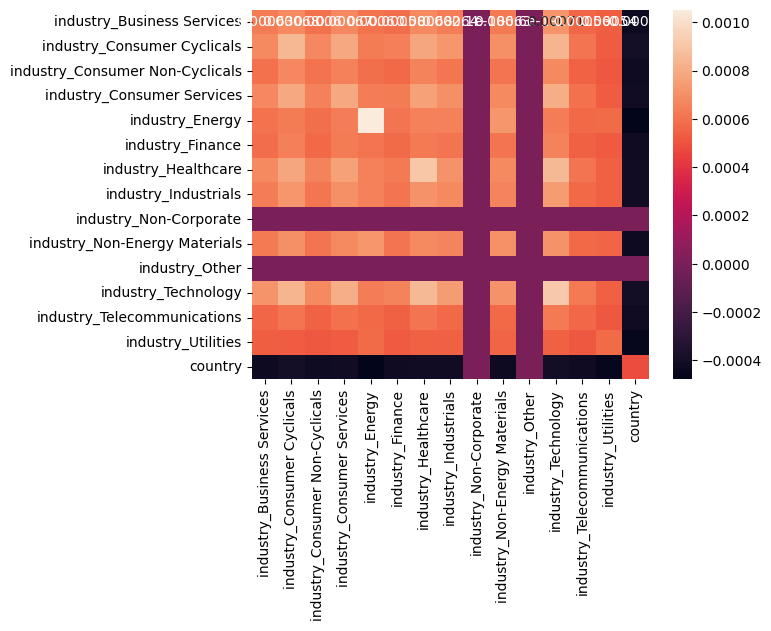

In [44]:
import seaborn as sns
%matplotlib inline
#plt.figure(figsize=(12, 12))  
sns.heatmap(df_factor_covar.loc['2022-12-20'], annot=True)

#### 4.5 Cleanup

In [ ]:
df_loadings = (
    df_loadings.drop(columns=["return_1d"])
    .melt(id_vars=["datetime", "id"], var_name="factor", ignore_index=True)
    .set_index(["datetime", "factor"])
    .pivot(columns="id")
    .droplevel(0, axis=1)
    .fillna(0)
)

df_loadings = df_loadings.sort_index().sort_index(axis=1)
df_factor_covar = df_factor_covar.sort_index().sort_index(axis=1)

df_idio = df_idio.fillna(0)
df_factor_covar = df_factor_covar.fillna(0)